# Curso: MCC639E

#### Integrantes

- Carlos Tello Tapia
- Lennin Quiso Córdova
- Milton Palacin Grijalva
___

# TERCERA PARTE: TEXT SUMMARIZATION

## I. Declaración de librerías

In [1]:
%load_ext autoreload
%autoreload 2
%aimport attention

# Tratamiento de datos
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Tratamiento de texto
# ==============================================================================

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras import backend as K
from attention import AttentionLayer

# Visualización Jupyter
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Configuración matplotlib
# ==============================================================================
# Para obtener el estilo de plot de seabonr
plt.style.use('seaborn-whitegrid')
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"

## II. Cargar y explorar el dataset

In [2]:
%%time
dataset_base = pd.read_csv("dataset_base.csv", sep='\t', encoding='utf-8')
dataset_base.sample(5)

CPU times: user 1.35 s, sys: 145 ms, total: 1.5 s
Wall time: 1.87 s


,category,title,date,abstract,content,content_for_summary,abstract_for_summary,content_for_topic,content_for_topic_lemma
1481,MINISTERIO PUBLICO,RESOLUCION N° 1016-2021-MP-FN,17/07/2021,Aceptan renuncia de Fiscal Adjunto Provincial ...,"Lima, 16 de julio de 2021 VISTOS Y CONSIDERAND...",lima de julio de vistos el oficio mp fn fsnced...,aceptan renuncia de fiscal adjunto provincial ...,lima julio vistos oficio fsncedcf remitido abo...,lima julio visto oficio fsncedcf remitido abog...
2369,MINISTERIO PUBLICO,RESOLUCION N° 915-2021-MP-FN,28/06/2021,Aceptan renuncia de fiscal del Distrito Fiscal...,"Lima, 28 de junio de 2021 VISTOS Y CONSIDERAND...",lima de junio de vistos los oficios nros mp fn...,aceptan renuncia de fiscal del distrito fiscal...,lima junio vistos oficios nros pjfspuno remiti...,lima junio visto oficio pjfspuno remitido abog...
117,PRODUCE,RESOLUCION MINISTERIAL N° 00256-2021-PRODUCE,18/08/2021,Designan Asesor II del Despacho Ministerial,"Lima, 17 de agosto de 2021 CONSIDERANDO: Que, ...",lima de agosto de que se encuentra vacante el ...,designan asesor ii del despacho ministerial,lima agosto encuentra vacante cargo asesor des...,lima agosto encontrar vacante cargo asesor des...
1671,AGENCIA DE PROMOCION DE LA INVERSION PRIVADA,ACUERDO N° 109-3-2021-CD,14/07/2021,Aprueban la incorporación de los Proyectos Enl...,Sesión Nº 109 del 09 de julio de 2021 Acuerdo ...,sesión del de julio de acuerdo proinversión cd...,aprueban la incorporación de los proyectos enl...,sesión julio acuerdo proinversión visto resume...,sesión julio acuerdo proinversión resumen ejec...
3591,ORGANISMO SUPERVISOR DE LA INVERSION EN ENERGI...,RESOLUCION N° 042-2021-OS/GRT,02/06/2021,Aprueban costos administrativos y operativos d...,"Lima, 31 de mayo de 2021 CONSIDERANDO: Que, co...",lima de mayo de que con la ley en adelante la ...,aprueban costos administrativos operativos del...,lima mayo adelante creó sistema seguridad ener...,lima mayo adelante crear sistema seguridad ene...


___
Utilizar las columnas: 
* **content_for_summary**
* **abstract_for_summary**

Estas columnas a diferencia de **content_for_topic** son textos pre-procesados sin stemmer o lemmatizer. Es necesario mantener la palabras originales para ayudar a la red a mejorar la exactitud en la generación del "summary" 
___

In [3]:
print("Total de normas legales en el dataset:", dataset_base.shape[0])

Total de normas legales en el dataset: 4037


___
Agregar la palablas (tokens) especiales al inicio y fin del abstract
___

In [4]:
%%time
# Función para marcar el texto que servira al Decoder del modelo Seq2Seq
dataset_base.abstract_for_summary = dataset_base.abstract_for_summary.apply(lambda t: "_START_ " + t + " _END_")
dataset_base.sample(5)

CPU times: user 1.73 ms, sys: 631 µs, total: 2.36 ms
Wall time: 2.11 ms


,category,title,date,abstract,content,content_for_summary,abstract_for_summary,content_for_topic,content_for_topic_lemma
3133,RELACIONES EXTERIORES,RESOLUCION SUPREMA N° 083-2021-RE,12/06/2021,Remiten al Congreso de la República la documen...,"Lima, 11 de junio de 2021 CONSIDERANDO: Que, ...",lima de junio de que el acuerdo entre el gobie...,_START_ remiten al congreso la documentación r...,lima junio acuerdo gobierno perú gobierno fede...,lima junio acuerdo gobierno perú gobierno fede...
550,RELACIONES EXTERIORES,RESOLUCION MINISTERIAL N° 0275-2021-RE,04/08/2021,Dan término a la designación de Agregada a la ...,"Lima, 30 de julio de 2021 VISTAS: La Resolució...",lima de julio de vistas la resolución minister...,_START_ dan término la designación de agregada...,lima julio vistas resolución ministerial desig...,lima julio visto resolución ministerial design...
1022,AMBIENTE,DECRETO SUPREMO N° 020-2021-MINAM,24/07/2021,Decreto Supremo que aprueba el Plan de Estánda...,El PRESIDENTE DE LA REPÚBLICA: CONSIDERANDO: Q...,el presidente que el numeral del de la constit...,_START_ decreto supremo que aprueba el plan de...,presidente numeral constitución política perú ...,presidente numeral constitución político perú ...
886,CONGRESO DE LA REPUBLICA,LEY N° 31315,26/07/2021,Ley de seguridad alimentaria y nutricional,EL PRESIDENTE DE LA REPÚBLICA POR CUANTO: EL C...,el presidente el congreso objeto de la ley el ...,_START_ ley de seguridad alimentaria nutricion...,presidente congreso objeto objeto presente est...,presidente congreso objeto objeto presente est...
531,JURADO NACIONAL DE ELECCIONES,RESOLUCION N° 0766-2021-JNE,05/08/2021,Dejan sin efecto la credencial otorgada a ciud...,Expediente N° JNE.2021090073 BOLOGNESI–ÁNCASH ...,expediente jne bolognesiáncash vacancia convoc...,_START_ dejan sin efecto la credencial otorgad...,expediente bolognesiáncash vacancia convocator...,expediente bolognesiáncash vacancia convocator...


___
Entender la distribución de las secuencias: anlizando el tamaño del contenido y el abstract. Este ejercicio ayuda a encontrar el tamaño máximo de las secuencias
___

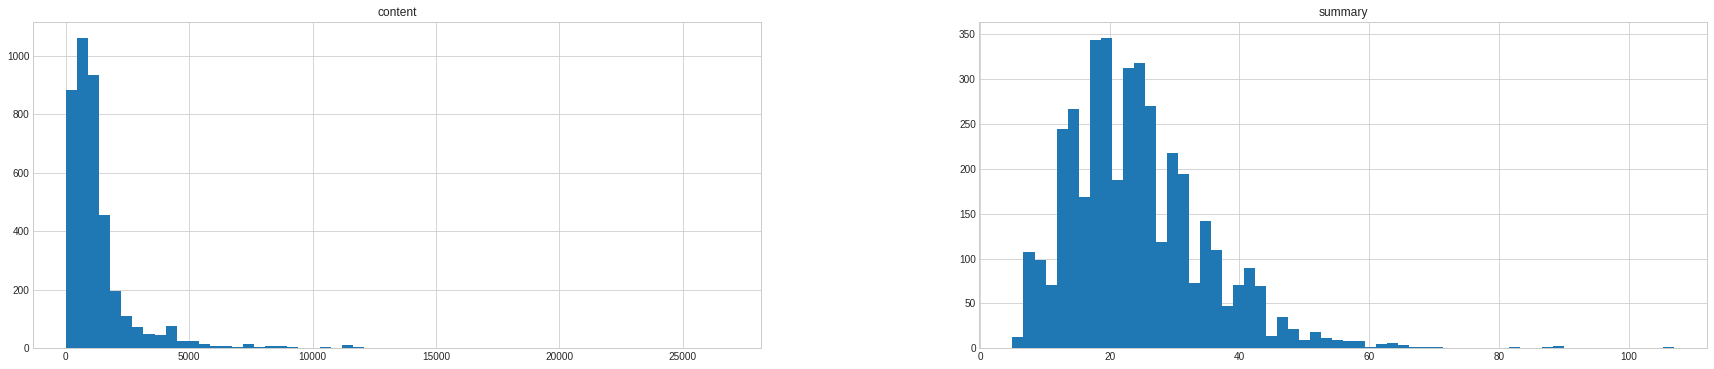

CPU times: user 905 ms, sys: 12.5 ms, total: 917 ms
Wall time: 923 ms


In [5]:
%%time
text_count = []
summary_count = []


for sent in dataset_base.content_for_summary:
    text_count.append(len(sent.split()))
for sent in dataset_base.abstract_for_summary:
    summary_count.append(len(sent.split()))

# Crear dataset para graficar histograma
graph_df = pd.DataFrame()
graph_df['content']=text_count
graph_df['summary']=summary_count

graph_df.hist(bins = 60, figsize=(30,6))
plt.show()

## III. Configurar dataset para dividir en datos de entranamiento y pruebas

___
Seleccionar el número máximo de secuencias (tokens-palabras) de acuero a la gráfica, de tal manera que concentre la mayor parte de contenido promedio y evitar los **outliers**.
___

In [6]:
%%time
# El modelo realizará las siguientes secuencias: abstract/summary entre 1-max_summary_len tokens y para contenido/content entre 1 y max_content_len tokesn.
max_len_content = 3000
max_len_summary = 35

print("="*50)

# Verificar el porcentaje de palabras en el content entre 1 y max_content_len
print("% content de palabras entre 1 y " + str(max_len_content) + ":",
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.content_for_summary.split()) > 100 and
                       len(v.content_for_summary.split()) <= 100 + max_len_content, axis=1)
            ].shape[0]/len(dataset_base.content_for_summary)
)

# Verificar el porcentaje de palabras en el abstract entre 1 y max_summary_len
print("% abstract de palabras entre 1 y " + str(max_len_summary) + ":",
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.abstract_for_summary.split()) > 5 and
                       len(v.abstract_for_summary.split()) <= 5 + max_len_summary, axis=1)
            ].shape[0]/len(dataset_base.abstract_for_summary)
)

print("="*50)

% content de palabras entre 1 y 3000: 0.9046321525885559
% abstract de palabras entre 1 y 35: 0.9202378003467921
CPU times: user 735 ms, sys: 9.63 ms, total: 745 ms
Wall time: 748 ms


___
Elegir secuencias mayores a 5 y menores a **max_content_len, max_summary_len** según sea el caso
___

In [7]:
%%time
dataset_pre = \
dataset_base[
    dataset_base.apply(lambda v: 
                       len(v.content_for_summary.split()) > 5 and
                       len(v.content_for_summary.split()) <= max_len_content and
                       len(v.abstract_for_summary.split()) > 5 and
                       len(v.abstract_for_summary.split()) <= max_len_summary, axis=1)
][["content_for_summary","abstract_for_summary"]]

dataset_pre.sample(5)

CPU times: user 715 ms, sys: 3.5 ms, total: 719 ms
Wall time: 718 ms


,content_for_summary,abstract_for_summary
3896,lima de mayo de visto el informe técnico grt e...,_START_ fijan margen comercial banda de precio...
2488,lima de junio de vistos el memorando minam vmg...,_START_ modifican la primera actualización del...
2297,lima de junio del visto el expediente que cont...,_START_ aprueban el presupuesto analítico de p...
1110,lima de julio de visto el acta de la octogésim...,_START_ formalizan el acuerdo de la octogésima...
3220,san bartolo de mayo de el concejo municipal de...,_START_ ordenanza que regula la expedición de ...


___
Dividir el dataset base en conjunto de entranamiento y pruebas
* $x\_tr\_i$, $y\_tr\_i$: datos (datasets) de entrenamiento
* $x\_val\_i$, $y\_val\_i$: datos (datasets) de validación
___

In [8]:
%%time
x_tr_i, x_val_i, y_tr_i, y_val_i = train_test_split(dataset_pre.content_for_summary.to_numpy(), dataset_pre.abstract_for_summary.to_numpy(), test_size=0.1, random_state=0, shuffle=True)
x_tr_i.shape, x_val_i.shape

CPU times: user 1.11 ms, sys: 279 µs, total: 1.39 ms
Wall time: 994 µs


((2901,), (323,))

## III. Tokenizar los dataset

___
<h3>Tratar palabras que aparecen raras veces</h3>  

____
Luego de tokenizar se revisará las  palabras que tienen menos uso, con la cantidad obtenida se vuelve a tokenizar (con el parámetro *num_words*) para tomar el grupo más frecuente.

* total_token: tamaño del vocabulario, es decir conteo por palabras única.
* total_thresh: Umbral de la frecuencia mímima
* total_rare: cantidad de palabras (conteo po palabra) con una frecuencia menor al total_thresh.
* total_token -  total_thresh: determina el número de palabras más comunes
___

___
Preparar tokenizer para el contenido en los datos de entranamiento
___

In [9]:
%%time
# Preparar tokenizer para el contenido en los datos de entranamiento
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(x_tr_i)
total_thresh = 5 # considerando a _START_ y _END_

total_token = 0
total_rare  = 0
freq = 0
total_freq = 0

# Leer el diccionario
for key,value in x_tokenizer.word_counts.items():
    total_token = total_token + 1
    total_freq = total_freq + value
    if value < total_thresh:
        total_rare = total_rare + 1
        freq = freq + value


print("="*50)
print("% de palabras raras en el vocabulario:",(total_rare/total_token)*100)
print("Covertura todal de las palabras raras:",(freq/total_freq)*100)
print("="*50)

# Preparar tokenizer para el contenido en los datos de entranamiento
x_tokenizer = Tokenizer(num_words = total_token - total_rare) 
x_tokenizer.fit_on_texts(x_tr_i)

# Convertir la secuencias de texto en una secuencia de enteros (i.e one-hot encodeing all the words)
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr_i) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val_i)

# Uniformizar la secuencia agregando ceros hasta cumplir el tamñao max_len_content
x_tr = pad_sequences(x_tr_seq,  maxlen=max_len_content, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_len_content, padding='post')

# Tamaño del vocabulario ( +1 po rel padding del token)
x_voc = x_tokenizer.num_words + 1

print("="*50)
print("Tamaño del vocabulario de X = {}".format(x_voc))
print("="*50)

% de palabras raras en el vocabulario: 55.773906671551806
Covertura todal de las palabras raras: 1.1584758296210573
Tamaño del vocabulario de X = 13279
CPU times: user 7.45 s, sys: 599 µs, total: 7.45 s
Wall time: 7.45 s


In [10]:
%%time
# Preparar "tokenizer" para el contenido/texto en los datos de entrenamiento
y_tokenizer = Tokenizer() 
y_tokenizer.fit_on_texts(y_tr_i)
total_thresh = 5 # considerando a _START_ y _END_

total_token = 0
total_rare  = 0
freq = 0
total_freq = 0

# Leer el diccionario del tokenizer
for key,value in y_tokenizer.word_counts.items():
    total_token = total_token + 1
    total_freq = total_freq + value
    if value < total_thresh:
        total_rare = total_rare + 1
        freq = freq + value


print("="*50)
print("% de palabras raras en el vocabulario:",(total_rare/total_token)*100)
print("Covertura todal de las palabras raras:",(freq/total_freq)*100)
print("="*50)

# Preparar tokenizer para el contenido en los datos de entranamiento
y_tokenizer = Tokenizer(num_words = total_token - total_rare) 
y_tokenizer.fit_on_texts(y_tr_i)

# Convertir la secuencias de texto en una secuencia de enteros (i.e one-hot encodeing all the words)
y_tr_seq = y_tokenizer.texts_to_sequences(y_tr_i) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val_i)

# Uniformizar la secuencia agregando ceros hasta cumplir el tamñao max_len_content
y_tr = pad_sequences(y_tr_seq,  maxlen=max_len_summary, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

# Tamaño del vocabulario ( +1 po rel padding del token)
y_voc = y_tokenizer.num_words + 1

print("="*50)
print("Tamaño del vocabulario de Y = {}".format(y_voc))
print("="*50)

% de palabras raras en el vocabulario: 73.2691149909693
Covertura todal de las palabras raras: 9.74046202023183
Tamaño del vocabulario de Y = 1333
CPU times: user 262 ms, sys: 0 ns, total: 262 ms
Wall time: 262 ms


## IV. Diseño del moldelo SecToSec + Attention
___

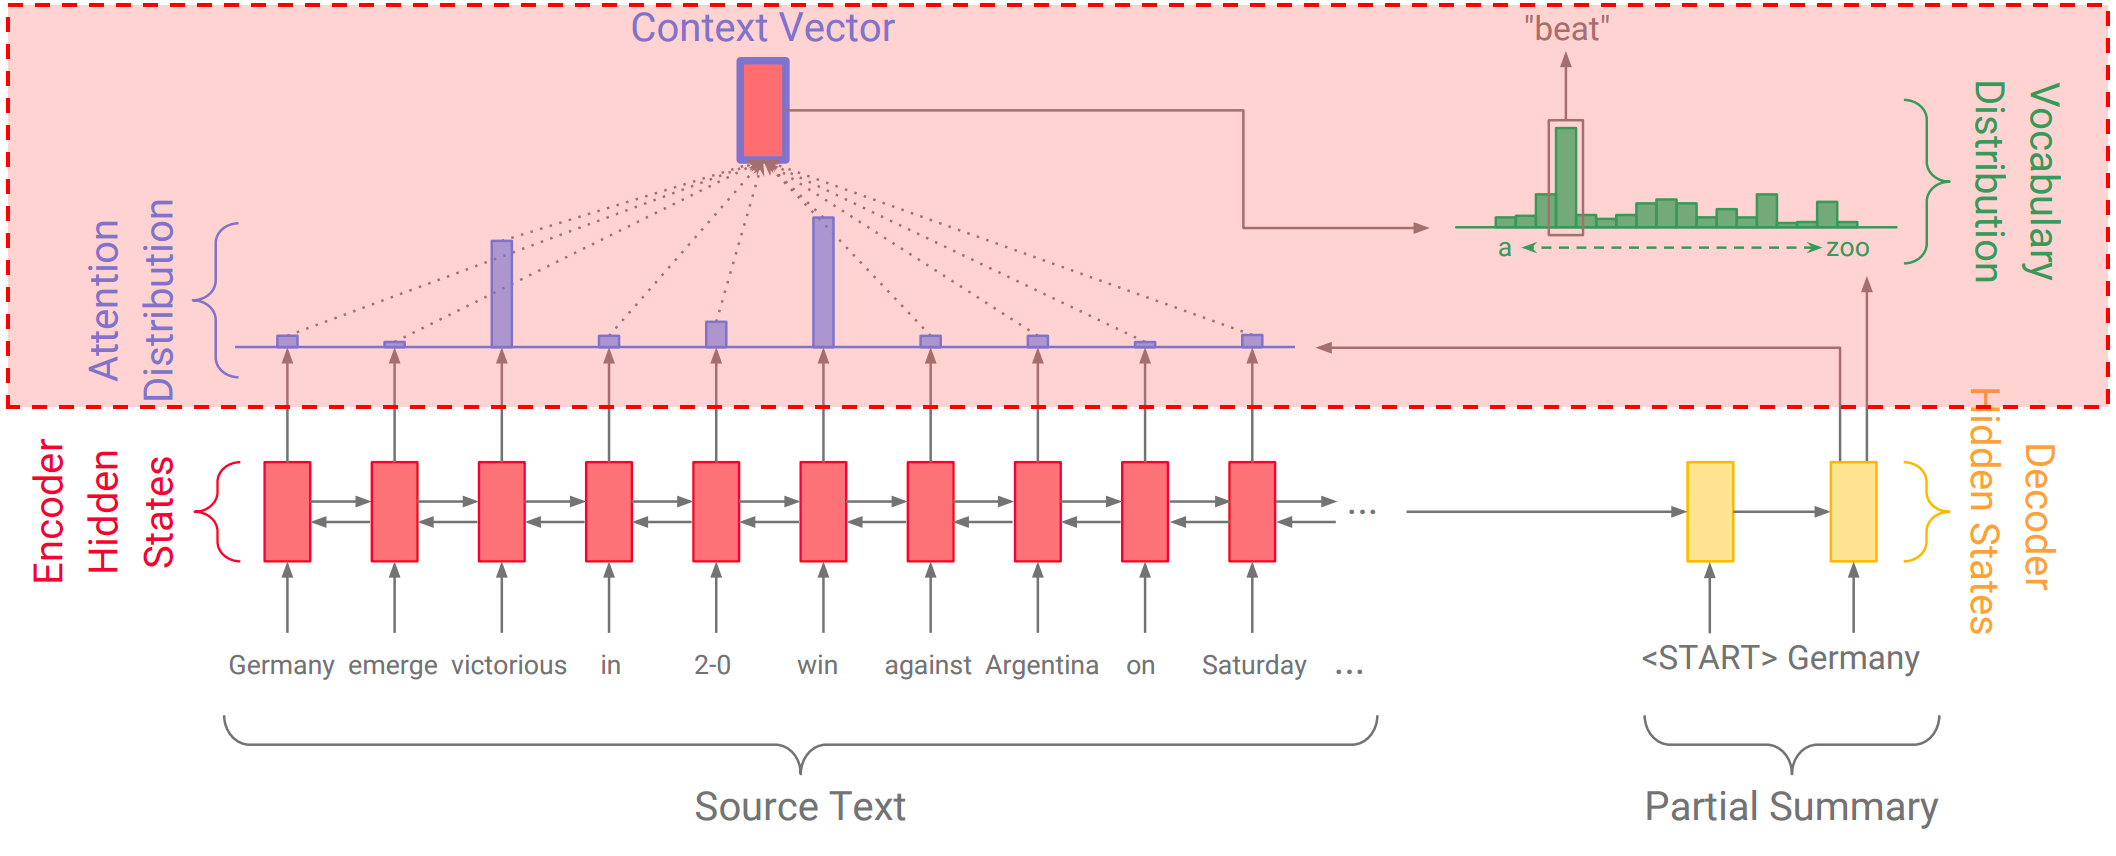

<em>Fuente: https://humboldt-wi.github.io/blog/research/information_systems_1920/nlp_text_summarization_techniques/</em>
___
Características principales:

* **Celda** es equivalente nodo o neurona.
* *state_h*: Estado oculto (estado anterior).
* *state_c*: Estado de celda (estado actual).
* **Return Sequences = True**: Cuando se asigna verdadero al párametro *return_sequences*, LSTM produce el estado oculto y el estado de la celda (*hidden state, cell state*) para cada iteración.
* **Return State = True**: Cuando se asigna verdadero al párametro *return_state*, LSTM produce el estado oculto y el estado de la celda solo al final de cada iteración.
* **Initial State**: Usado para inicializar el estado interno del LSTM al inicio de la iteración.
* **Stacked LSTM**: Un pila de LSTM tiene multiples capas de LSTM puesta una sobre otra. Esta técnica  mejora la representación de la secuencia.
* **Dropout**: En los pasos anterior se realizó normalización, limpieza y tratamiento del Outliers en los datos. Dropout permite mejorar los resultados, dado que uno de los problemas de LSTM es el Overfit. Actua excluyendo de manera probabilística la activación y actualización de pesos durante el entrenamiento de la red, en nuestro caso la probailidad es 0.4.
* <h4 style="background-color: #FFFF00">El presente modelo se utiliza: 3 stacked LSTM para el ENCODER, 1 stacker LSTM para el DECODER y una capas de ATTENTION.</h4>
___

In [11]:
%%time

# Limpiar las sesiones anteriores
K.clear_session()

# Dimensión de la capa de LSTM
latent_dim = 300
# Dimensión de la capa de Embedding
embedding_dim = 200


# ======================================================================================================= #
#                                                                                                         #
#                                                 ENCODER                                                 #
#                                                                                                         #
# ======================================================================================================= #


# Entradas del ENCODER: es el tamaño del vocabulario del contenido
encoder_inputs = Input(shape=(max_len_content,))

# Capa de EMBEDDING: Capa de entrada al ENCODER
# x_voc: Vocabulario de "contenido".
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

# Componente RNN LSTM 1: capa oculta
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# Componente RNN LSTM 2: capa oculta
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True, dropout=0.4, recurrent_dropout=0)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# Componente RNN LSTM 3: capa oculta
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# statet_h: Vector de estados ocultos anteriores 
# state_c: Vector de estados de celda

# ======================================================================================================= #
#                                                                                                         #
#                                                 DECODER                                                 #
#                                                                                                         #
# ======================================================================================================= #

# -------------------------------------------------------------------------------------------------------
# Configurar el DECODER, se utiliza los "ecoder_states" del ENCODER como estado inicial
# -------------------------------------------------------------------------------------------------------

# Entradas del DECODER:
decoder_inputs = Input(shape=(None,))

# Capa de EMBEDDING: Capa de entrada al DECODER
# y_voc: Vocabulario de "abastract".
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Componente RNN LSTM: capa oculta del DECODER
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0)
# [state_h, state_c] vector de contexto, vector que representa el estado del ENCODER o de estado anterior
decoder_outputs, decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# ======================================================================================================= #
#                                                                                                         #
#                                               ATTENTION                                                 #
#                                                                                                         #
# ======================================================================================================= #

# Capa de ATTENTION: Capa oculta
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# -------------------------------------------------------------------------------------------------------
# IMPORTANTE: Concatenar el DECODER con el ENCODER y el ATTENTION
# -------------------------------------------------------------------------------------------------------
# Concatenar la entrada attention input y salida del LSTM decoder.
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# -------------------------------------------------------------------------------------------------------

#Capa densa: Capa de salida
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Modelo definido
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 3000, 200)    2655800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 3000, 300),  601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

____
Compilar el modelo para su posterior ejecución: EarlyStopping dejará de entrenar al modelo cuando la perdidad de validación (val_loss) empiece a incrementar.
  
Debido a que tenemos entrada y salidas tipo  One-Hot-Encode se usa sparse_categorical_crossentropy para evaluar el pérdida en cada iteración.

Utilizar RMSprop nos proporciona más dinamismo en el tratamiento de las gradientes:

* Mantener un promedio dinámico del cuadrado de las gradientes
* Divida la gradiente por la raíz de este promedio.
____

In [12]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

## V. Entrenamiento
___
Realizar el entranamiento: para poder ejecutar el entranamiento de manera loca se configura lo siguiente:
* **epochs**: 30 épocas.
* **bach_size**: de tamaño 8.
___

In [13]:
%%time
history=model.fit(
    [x_tr,y_tr[:,:-1]], 
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:], 
    epochs=30, callbacks=[es], batch_size=8, 
    validation_data= ([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/30
363/363 [==============================] - 858s 2s/step - loss: 2.6307 - val_loss: 2.3232
Epoch 2/30
363/363 [==============================] - 442s 1s/step - loss: 2.1351 - val_loss: 1.9880
Epoch 3/30
363/363 [==============================] - 232s 640ms/step - loss: 1.8799 - val_loss: 1.8042
Epoch 4/30
363/363 [==============================] - 228s 629ms/step - loss: 1.7211 - val_loss: 1.7057
Epoch 5/30
363/363 [==============================] - 230s 632ms/step - loss: 1.6054 - val_loss: 1.6842
Epoch 6/30
363/363 [==============================] - 229s 632ms/step - loss: 1.5176 - val_loss: 1.5778
Epoch 7/30
363/363 [==============================] - 230s 633ms/step - loss: 1.4294 - val_loss: 1.5399
Epoch 8/30
363/363 [==============================] - 234s 644ms/step - loss: 1.3509 - val_loss: 1.4720
Epoch 9/30
363/363 [==============================] - 233s 643ms/step - loss: 1.2814 - val_loss: 1.4593
Epoch 10/30
363/363 [==============================] - 233s 642ms/step

___
Guardar los pesos y el modelo 
___

In [35]:
model.save_weights("model_weights.h5")
model.save("model.h5")

___
Verificar la función de pérdida a lo larfo de las épocas/iteraciones de los datos de entranamiento y validación:  
* En la gráfica se podemos inferir que la pérdida de validación es mayor entre la época 1 y 4 de forma sucesivas. Por tanto, el entrenamiento se detiene en épocas mayor a 20.
___

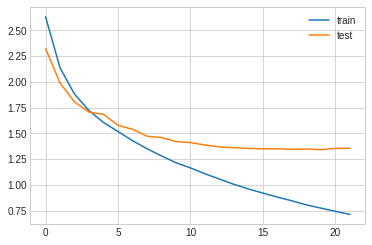

In [14]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## VI. Proceso de inferencia

___
Crear el diccionario para convertir el índice en una palabra para el vocabulario de origen y destino:
___

In [15]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

___
Definir la red de inferencia. Similar a la red original, con la gran diferencia que esta red hace uso de los pesos y la predicción del entranamiento.
___

In [16]:
%%time

# ======================================================================================================= #
#                                                                                                         #
#                                                 ENCODER                                                 #
#                                                                                                         #
# ======================================================================================================= #

# Codificar (Encode) la secuencia de entrada (texto/contenido) para obtener el vector de características.
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])


# ======================================================================================================= #
#                                                                                                         #
#                                                 DECODER                                                 #
#                                                                                                         #
# ======================================================================================================= #

# Los siguientes  tensores mantendrán los estados del paso de tiempo anterior
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_content, latent_dim))

# Obtener lso embeddings de la secuencia del decodificador
dec_emb2= dec_emb_layer(decoder_inputs) 

# Para predecir la siguiente palabra en la secuencia, asigna el estado inicial a los estados/tensores del paso anterior.
# 
# -------------------------------------------------------------------------------------------------------
# IMPORTANTE: Recuperar el stacked LSTM: para obtener los vectores de estado en los estados/tensores del paso anterior.
# -------------------------------------------------------------------------------------------------------
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# ======================================================================================================= #
#                                                                                                         #
#                                               ATTENTION                                                 #
#                                                                                                         #
# ======================================================================================================= #

# -------------------------------------------------------------------------------------------------------
# IMPORTANTE: Infrencia del ATTENTION: Concatenar el DECODER con el ENCODER y el ATTENTION
# -------------------------------------------------------------------------------------------------------
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# Una capa densa de softmax para generar distribución probabilística. sobre el vocabulario de destino.
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Modelo decodificaro (DECODER) final
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

CPU times: user 328 ms, sys: 1.94 ms, total: 330 ms
Wall time: 328 ms


___
Definar una función para el proceso de inferencia.
___

In [17]:
def decode_sequence(input_seq):
    # Codifica la entrada como vectores de estado
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Genere una secuencia de destino vacía de longitud 1.
    target_seq = np.zeros((1, 1))

    # Complete la primera palabra de la secuencia de destino con la palabra inicial "start" de _START_
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''

    # Iterar hasta que se de la condición de parada
    while not stop_condition:

        # Decodificar la entrad< con ayuda de los  vectores de estado del encode de entrada
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Obtener un token (palabra)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        # Verificar si el token es el final de un conteido "end" de _END_
        if sampled_token != 'end':
            decoded_sentence += ' ' + sampled_token

        # Condición de salida: cuando se cumple la longitud máxima o se encuentra la palabra final.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Actualizar la secuencia de destino (de longitud 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Actualizar estados internos
        e_h, e_c = h, c

    return decoded_sentence

___
Definir las funciones para convertir una secuencia de números enteros en una secuencia de palabras para el abstract y el contenido:
___

In [18]:
def seq2summary(input_seq):

    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['start']) and i != target_word_index['end']:
            newString = newString + reverse_target_word_index[i] + ' '
    return newString


def seq2text(input_seq):
    
    newString = ''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


In [19]:
#y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]
#y_val[0].shape[1]

In [20]:

#encoder_model.predict(x_val[12].reshape(1,max_content_len))

In [23]:
%%time
for i in range(20,50):
    print("="*100)
    print("Contenido:",seq2text(x_val[i])[0:1000] + "...")
    print("="*100)
    print("Abastract original:",seq2summary(y_val[i]))
    print("="*100)
    print("Abstract predecido:",decode_sequence(x_val[i].reshape(1,max_len_content)))
    print("="*100)
    print("\n")
    

# print("Review:",seq2text(x_val[i]))
# print("Original summary:",seq2summary(y_val[i]))
# print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_content)))
# print("\n")
#     print("Review:",seq2text(x_tr[i]))
#     print("Original summary:",seq2summary(y_tr[i]))
#     print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_content_len)))
#     print("\n")

Contenido: lima de agosto de vistos el informe mimp omi de la oficina de modernización institucional el memorándum mimp ogpp de la oficina general de planeamiento presupuesto que mediante decreto legislativo modificatoria se aprueba la ley de organización funciones del ministerio de la mujer poblaciones vulnerables que determina su ámbito de competencia funciones estructura orgánica básica como organismo rector en las políticas nacionales sectoriales sobre mujer promoción protección de las poblaciones vulnerables que los numerales del de la ley ley orgánica del poder ejecutivo modificatorias establecen que los ministerios son organismos del poder ejecutivo que comprenden uno varios sectores considerando su homogeneidad finalidad que estos diseñan establecen ejecutan supervisan políticas nacionales sectoriales asumiendo la rectoría respecto de ellas que el de la ley ley marco de modernización de la gestión del estado modificatorias establece que el proceso de modernización de la gestión

In [25]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)

In [37]:
from keras.models import load_model
# load model
new_model = load_model('model.h5', custom_objects={"AttentionLayer": AttentionLayer})

# summarize model.
new_model.summary()

TypeError: Cannot convert a symbolic Keras input/output to a numpy array. This error may indicate that you're trying to pass a symbolic value to a NumPy call, which is not supported. Or, you may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.

In [28]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 3000, 200)    2655800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 3000, 300),  601200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________